In [1]:
import os
from pathlib import Path

import numpy as np
from openslide import OpenSlide
from PIL import Image
from torchvision.datasets.folder import default_loader

In [2]:
import staintools

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
from violet.utils.preprocessing import extract_svs_tiles, get_he_image, extract_tif_tiles, get_svs_array, normalize_he_image
from violet.utils.dataloaders import listfiles

In [6]:
# fps = [
#     '/home/estorrs/violet/data/he/ffpe/tcia_pda/train/C3L-00017-21/C3L-00017-21_100_104.jpeg',
#     '/home/estorrs/violet/data/he/ffpe/tcia_pda/train/C3L-00277-26/C3L-00277-26_100_120.jpeg',
#     '/home/estorrs/violet/data/he/ffpe/tcia_pda/train/C3L-00189-22/C3L-00189-22_100_539.jpeg',
#     '/home/estorrs/violet/data/he/ffpe/tcia_ccrcc/train/C3L-00011-21/C3L-00011-21_100_37.jpeg',
#     '/home/estorrs/violet/data/he/ffpe/tcia_ccrcc/train/C3L-00165-22/C3L-00165-22_105_66.jpeg',
#     '/home/estorrs/violet/data/st/ccrcc_ffpe_08032021/train/HT282N1_S1H3Fs4U1/HT282N1_S1H3Fs4U1_AAACTCGTGATATAAG-1.jpeg',
#     '/home/estorrs/violet/data/st/ccrcc_ffpe_08032021/train/HT293N1_S1H3Fs1U1/HT293N1_S1H3Fs1U1_AACAATACATTGTCGA-1.jpeg',
#     '/home/estorrs/violet/data/st/pdac_ffpe_07292021/train/HT270P1_S1H1Fs5U1/HT270P1_S1H1Fs5U1_AAACTCGGTTCGCAAT-1.jpeg',
#     '/home/estorrs/violet/data/st/pdac_ffpe_07292021/train/HT270P1_S1H1Fs5U1/HT270P1_S1H1Fs5U1_AGACAGGCATCTCAGC-1.jpeg'
# ]
fps = sorted(listfiles('/data/tcia/PDA_preprocessed_small_raw/'))
fps = np.random.choice(fps, size=100)
fps = [fp for fp in fps if np.count_nonzero(np.asarray(Image.open(fp))==0) < 100]
fps[:64]
fps

['/data/tcia/PDA_preprocessed_small_raw/C3L-01032-21/C3L-01032-21_176_66.jpeg',
 '/data/tcia/PDA_preprocessed_small_raw/C3L-01031-21/C3L-01031-21_69_218.jpeg',
 '/data/tcia/PDA_preprocessed_small_raw/C3L-00017-21/C3L-00017-21_28_81.jpeg',
 '/data/tcia/PDA_preprocessed_small_raw/C3L-00599-21/C3L-00599-21_139_120.jpeg',
 '/data/tcia/PDA_preprocessed_small_raw/C3L-00589-21/C3L-00589-21_376_87.jpeg',
 '/data/tcia/PDA_preprocessed_small_raw/C3L-01031-21/C3L-01031-21_157_75.jpeg',
 '/data/tcia/PDA_preprocessed_small_raw/C3L-01037-21/C3L-01037-21_219_176.jpeg',
 '/data/tcia/PDA_preprocessed_small_raw/C3L-01036-21/C3L-01036-21_53_41.jpeg',
 '/data/tcia/PDA_preprocessed_small_raw/C3L-01032-21/C3L-01032-21_165_52.jpeg',
 '/data/tcia/PDA_preprocessed_small_raw/C3L-01031-21/C3L-01031-21_185_105.jpeg',
 '/data/tcia/PDA_preprocessed_small_raw/C3L-01031-21/C3L-01031-21_49_110.jpeg',
 '/data/tcia/PDA_preprocessed_small_raw/C3L-01052-21/C3L-01052-21_177_212.jpeg',
 '/data/tcia/PDA_preprocessed_small_ra

/data/tcia/PDA_preprocessed_small_raw/C3L-00277-21/C3L-00277-21_123_83.jpeg


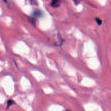

/data/tcia/PDA_preprocessed_small_raw/C3L-01037-21/C3L-01037-21_77_172.jpeg


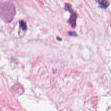

/data/tcia/PDA_preprocessed_small_raw/C3L-00625-21/C3L-00625-21_108_218.jpeg


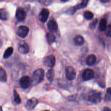

/data/tcia/PDA_preprocessed_small_raw/C3L-01036-21/C3L-01036-21_54_37.jpeg


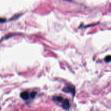

/data/tcia/PDA_preprocessed_small_raw/C3L-00885-21/C3L-00885-21_45_70.jpeg


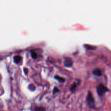

/data/tcia/PDA_preprocessed_small_raw/C3L-01037-21/C3L-01037-21_89_194.jpeg


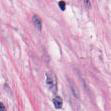

/data/tcia/PDA_preprocessed_small_raw/C3L-00189-21/C3L-00189-21_106_419.jpeg


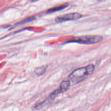

/data/tcia/PDA_preprocessed_small_raw/C3L-00625-21/C3L-00625-21_71_403.jpeg


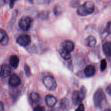

/data/tcia/PDA_preprocessed_small_raw/C3L-00189-21/C3L-00189-21_51_618.jpeg


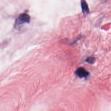

/data/tcia/PDA_preprocessed_small_raw/C3L-00277-21/C3L-00277-21_221_146.jpeg


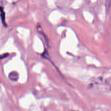

In [78]:
for fp in fps[:10]:
    print(fp)
    im = default_loader(fp)
    im.show()

In [79]:
# x = np.asarray(default_loader(fp))
# x

In [80]:
w = np.asarray(default_loader(fp)).shape[0]
ref = np.full((w * 8, w * 8, 3), 255)
queue = list(fps)
for r in range(8):
    for c in range(8):
        img = np.asarray(default_loader(queue.pop()))
        ref[r*w:(r + 1)*w, c*w:(c + 1)*w] = img
ref = ref.astype(np.uint8)
ref.shape

(888, 888, 3)

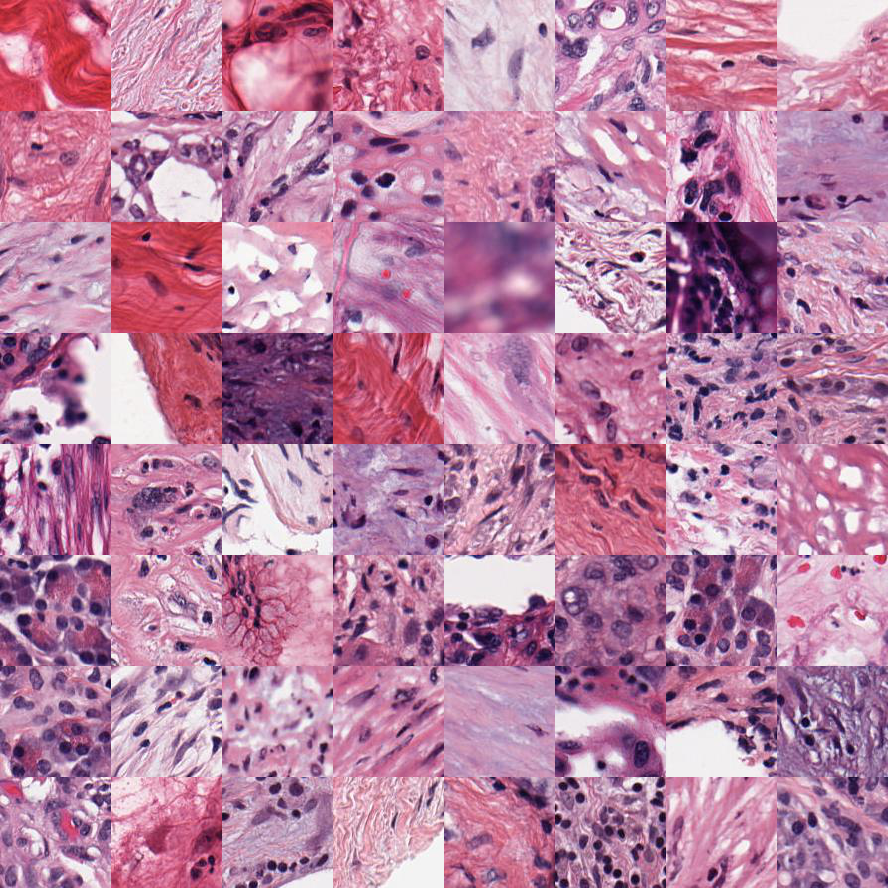

In [81]:
from PIL import Image
im = Image.fromarray(ref)
im

In [82]:
# im.save('/home/estorrs/violet/violet/data/pancreas_mosaic.jpeg')

In [7]:
# ref = '/home/estorrs/violet/data/he/ffpe/tcia_ccrcc/train/C3L-00165-22/C3L-00165-22_105_66.jpeg'
# ref = '/home/estorrs/violet/data/he/ffpe/tcia_pda/train/C3L-00017-21/C3L-00017-21_100_104.jpeg'
ref = '/home/estorrs/violet/violet/data/pancreas_mosaic.jpeg'
target = staintools.read_image(ref)
# Standardize brightness (optional, can improve the tissue mask calculation)
target = staintools.LuminosityStandardizer.standardize(target)

# Stain normalize
normalizer = staintools.StainNormalizer(method='vahadane')
normalizer.fit(target)

In [86]:
import matplotlib.pyplot as plt
def plot_normalized(fps, figsize=None):
    fig, axs = plt.subplots(ncols=len(fps), nrows=2, figsize=figsize)
    for i, fp in enumerate(fps):
        im = default_loader(fp)
        img = np.asarray(im)
        axs[0, i].imshow(img)
        axs[0, i].set_xticks([])
        axs[0, i].set_yticks([])
        
        to_transform = staintools.read_image(fp)
        to_transform = staintools.LuminosityStandardizer.standardize(to_transform)
        transformed = normalizer.transform(to_transform)
        axs[1, i].imshow(transformed)
        axs[1, i].set_xticks([])
        axs[1, i].set_yticks([])
    plt.subplots_adjust(wspace=0, hspace=0)

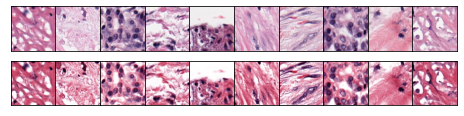

In [87]:
plot_normalized(fps[:10], figsize=(8, 2))

In [88]:
st_fps = sorted(listfiles('/data/violet/st/pdac_ffpe_raw/train/HT270P1_S1H1Fs5U1/'))
st_fps = np.random.choice(st_fps, size=64)

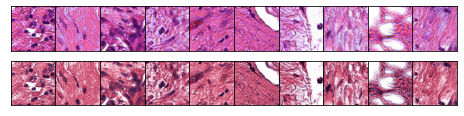

In [89]:
plot_normalized(st_fps[:10], figsize=(8, 2))

In [45]:
img = get_svs_array('/data/tcia/PDA/C3L-00102-22.svs', scale=1.)
img.shape

(29259, 27887, 3)

In [46]:
s = img[14000:18000, 14000:18000]

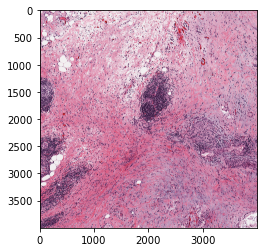

In [47]:
plt.imshow(s)

In [48]:
# ref = '/home/estorrs/violet/data/he/ffpe/tcia_ccrcc/train/C3L-00165-22/C3L-00165-22_105_66.jpeg'
# # ref = '/home/estorrs/violet/data/he/ffpe/tcia_pda/train/C3L-00017-21/C3L-00017-21_100_104.jpeg'
# target = staintools.read_image(ref)
# Standardize brightness (optional, can improve the tissue mask calculation)
# target = staintools.LuminosityStandardizer.standardize(s)
# normalizer = staintools.StainNormalizer(method='vahadane')
# normalizer.fit(target)

CPU times: user 9min 45s, sys: 3.69 s, total: 9min 49s
Wall time: 14.8 s


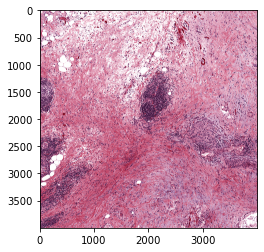

In [49]:
%%time
# to_transform = staintools.read_image(fp)
to_transform = staintools.LuminosityStandardizer.standardize(s)
transformed = normalizer.transform(to_transform)
plt.imshow(transformed)

In [53]:
import tifffile
st_img = tifffile.imread('/data/spatial_transcriptomics/highres_images/pdac/B1_HT270P1-S1H1Fs5U1.tif')
st_img.shape

(19962, 19651, 3)

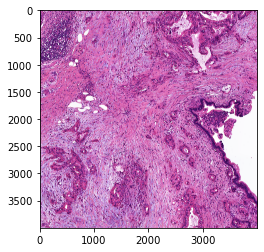

In [55]:
st_s = st_img[12000:16000, 12000:16000]
plt.imshow(st_s)

CPU times: user 9min 32s, sys: 7.15 s, total: 9min 39s
Wall time: 14.3 s


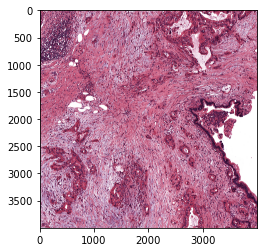

In [56]:
%%time
# to_transform = staintools.read_image(fp)
to_transform = staintools.LuminosityStandardizer.standardize(st_s)
transformed = normalizer.transform(to_transform)
plt.imshow(transformed)

In [8]:
ref_img = Image.open(ref)
np.mean(np.asarray(ref_img), axis=(0, 1))

array([185.96101549, 130.72287279, 163.37277311])

In [151]:
??is_background

In [156]:
np.asarray(ref_img)[0, 0]

array([134,  89, 128], dtype=uint8)

In [39]:
def normalize_image(img, b=2000):
    rows = img.shape[0] // b
    cols = img.shape[1] // b
    final = np.zeros(img.shape, dtype=np.uint8)
    print(rows, cols)
    for r in range(rows):
        for c in range(cols):
            print(r, c)
            r_i = (r + 1) * b if r != rows - 1 else img.shape[0] + 1
            c_i = (c + 1) * b if c != cols - 1 else img.shape[1] + 1
            tile = img[r * b:r_i, c * b:c_i]
            to_transform = staintools.LuminosityStandardizer.standardize(tile)
            transformed = normalizer.transform(to_transform)

            final[r * b:r_i, c * b:c_i] = transformed
    return final

def normalize_image_v2(img, thresh=250.):
    means = np.mean(img, axis=-1)
    mask = means >= thresh
    new = img.copy()
    
    pool = new[~mask]
    pool = pool[np.random.choice(np.arange(pool.shape[0]), size=np.count_nonzero(mask))]
#     np.random.shuffle(pool)
#     idxs = pool[np.random.choice(np.arange(pool.shape[0]), size=np.count_nonzero(mask))]
#     pool = pool[:np.count_nonzero(mask)]
#     return pool
#     return idxs
#     print(pool.shape, new[mask].shape)
    new[mask] = pool
#     return new
    
#     new[mask] = [194, 154, 180]
    
    to_transform = staintools.LuminosityStandardizer.standardize(new)
    transformed = normalizer.transform(to_transform)
#     transformed = normalize_image(new, b=1024)
    transformed[mask] = img[mask]
    
    return transformed, new

In [19]:

new = normalize_image_v2(np.asarray(ref_img))
new.shape

here
here


(888, 888, 3)

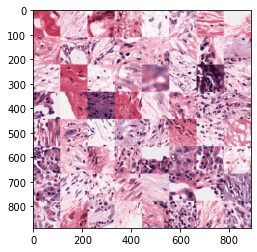

In [20]:
plt.imshow(new)

In [12]:
import tifffile
st_img = tifffile.imread('/data/spatial_transcriptomics/highres_images/pdac/B1_HT270P1-S1H1Fs5U1.tif')
st_img.shape

(19962, 19651, 3)

In [46]:
%%time
new, sampled = normalize_image_v2(st_img)
new, sampled = normalize_image_v2(new)
new

CPU times: user 5h 21min 58s, sys: 2min 54s, total: 5h 24min 52s
Wall time: 11min 1s


array([[[195,  62,  94],
        [195,  62,  94],
        [195,  62,  94],
        ...,
        [195,  62,  94],
        [195,  62,  94],
        [195,  62,  94]],

       [[195,  62,  94],
        [195,  62,  94],
        [195,  62,  94],
        ...,
        [195,  62,  94],
        [195,  62,  94],
        [195,  62,  94]],

       [[195,  62,  94],
        [195,  62,  94],
        [195,  62,  94],
        ...,
        [195,  62,  94],
        [195,  62,  94],
        [195,  62,  94]],

       ...,

       [[195,  62,  94],
        [195,  62,  94],
        [195,  62,  94],
        ...,
        [242, 193, 209],
        [195,  62,  94],
        [195,  62,  94]],

       [[195,  62,  94],
        [195,  62,  94],
        [195,  62,  94],
        ...,
        [195,  62,  94],
        [195,  62,  94],
        [195,  62,  94]],

       [[195,  62,  94],
        [195,  62,  94],
        [195,  62,  94],
        ...,
        [195,  62,  94],
        [195,  62,  94],
        [195,  62,  94]]

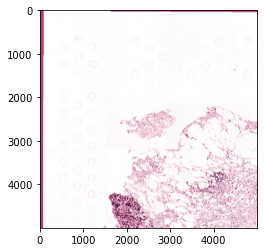

In [47]:
import matplotlib.pyplot as plt
plt.imshow(new[:5000, :5000])

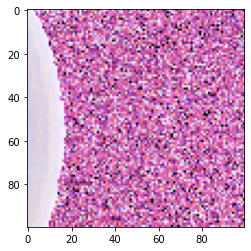

In [37]:
import matplotlib.pyplot as plt
plt.imshow(sampled[1000:1100, 1000:1100])

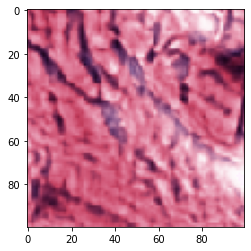

In [38]:
plt.imshow(new[4900:5000, 4900:5000])

In [48]:
im = Image.fromarray(new)
im.save('/data/sandbox/test8.tif')

In [40]:
he_img = get_svs_array('/data/tcia/PDA/C3L-00102-22.svs', scale=1.)

In [41]:
%%time
norm_he, sampled = normalize_image_v2(he_img)

CPU times: user 4h 10min 32s, sys: 3min 47s, total: 4h 14min 19s
Wall time: 9min 32s


In [43]:
im = Image.fromarray(norm_he[0])
im.save('/data/sandbox/test7.tif')

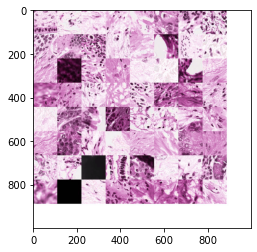

In [201]:
plt.imshow(new)

In [144]:
%%time
# to_transform = staintools.read_image(fp)
to_transform = staintools.LuminosityStandardizer.standardize(st_img)


CPU times: user 26.1 s, sys: 6.98 s, total: 33 s
Wall time: 9.37 s


In [145]:
%%time
transformed = normalizer.transform(to_transform)
# plt.imshow(transformed)

CPU times: user 2h 22min 31s, sys: 1min 16s, total: 2h 23min 47s
Wall time: 4min 39s


In [147]:
im = Image.fromarray(transformed)
im.save('/data/sandbox/test5.tif')

In [140]:
from importlib import reload
reload(staintools)

<module 'staintools' from '/home/estorrs/miniconda3/envs/violet/lib/python3.8/site-packages/staintools/__init__.py'>

In [123]:
??normalizer.transform

In [98]:
8777 // 2000

4

In [ ]:
is_background()

In [113]:
from violet.utils.preprocessing import is_background

def normalize_image(img, b=2000):
    rows = img.shape[0] // b
    cols = img.shape[1] // b
    final = np.zeros(img.shape, dtype=np.uint8)
    print(rows, cols)
    for r in range(rows):
        for c in range(cols):
            print(r, c)
            r_i = (r + 1) * b if r != rows - 1 else img.shape[0] + 1
            c_i = (c + 1) * b if c != cols - 1 else img.shape[1] + 1
            tile = img[r * b:r_i, c * b:c_i]
            
            if not is_background(tile, coverage=.25):

                to_transform = staintools.LuminosityStandardizer.standardize(tile)
                transformed = normalizer.transform(to_transform)

                final[r * b:r_i, c * b:c_i] = transformed
    return final
            

In [141]:
%%time
norm = normalize_image(st_img[:8888, :7777], b=1028)

8 7
0 0
0 1
0 2
0 3
0 4
0 5
0 6
1 0
1 1
1 2
1 3
1 4
1 5
1 6
2 0
2 1
2 2
2 3
2 4
2 5
2 6
3 0
3 1
3 2
3 3
3 4
3 5
3 6
4 0
4 1
4 2
4 3
4 4
4 5
4 6
5 0
5 1
5 2
5 3
5 4
5 5
5 6
6 0
6 1
6 2
6 3
6 4
6 5
6 6
7 0
7 1
7 2
7 3
7 4
7 5
7 6
CPU times: user 42min 59s, sys: 25.4 s, total: 43min 24s
Wall time: 50.3 s


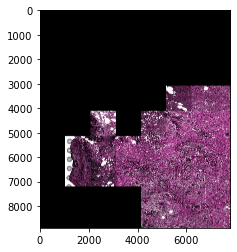

In [142]:
plt.imshow(norm)

In [143]:
tifffile.imwrite('/data/sandbox/test4.tif', data=norm)

In [96]:
# random shred
from torchvision.transforms import RandomResizedCrop
t = RandomResizedCrop(128, scale=(.00001, .01), ratio=(1., 1.))

# def shred_img(img, size=(64, 1024), n=5):
#     for i in range(n):
#         tile_size = int(np.random.uniform(low=size[0], high=size[1]))
        
    


# he_imgs = 

True


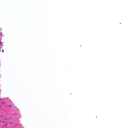

True


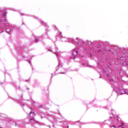

True


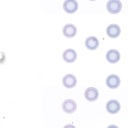

False


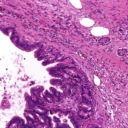

False


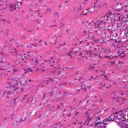

False


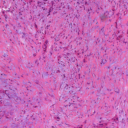

True


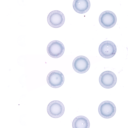

False


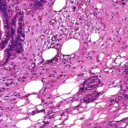

False


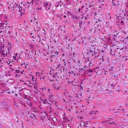

False


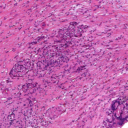

True


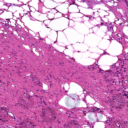

False


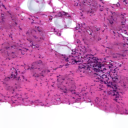

False


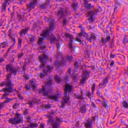

False


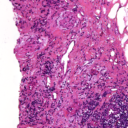

False


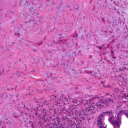

False


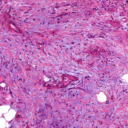

True


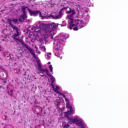

False


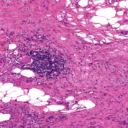

True


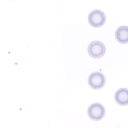

False


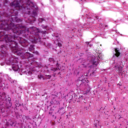

False


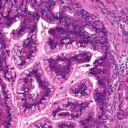

True


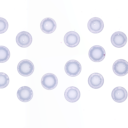

False


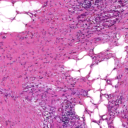

False


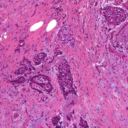

False


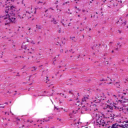

False


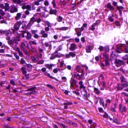

True


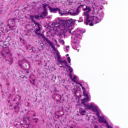

False


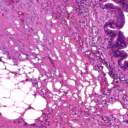

True


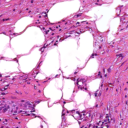

True


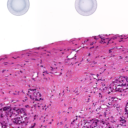

False


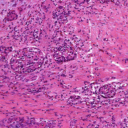

False


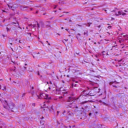

True


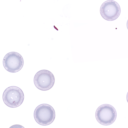

True


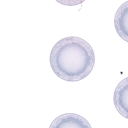

False


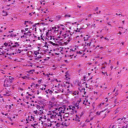

False


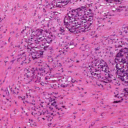

False


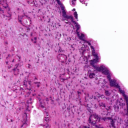

False


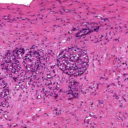

True


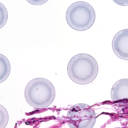

False


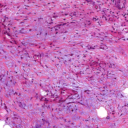

True


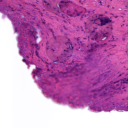

False


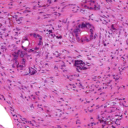

False


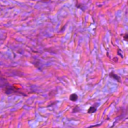

True


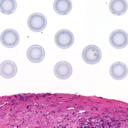

False


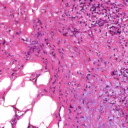

True


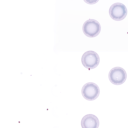

False


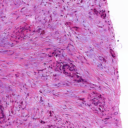

True


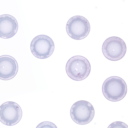

False


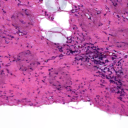

False


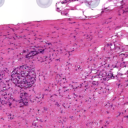

False


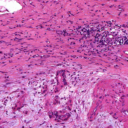

False


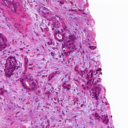

True


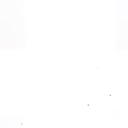

False


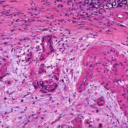

True


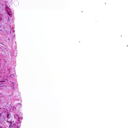

True


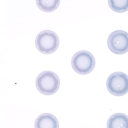

False


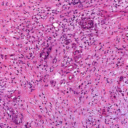

False


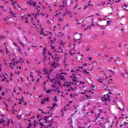

False


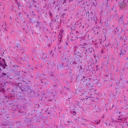

True


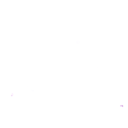

False


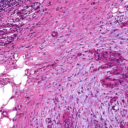

False


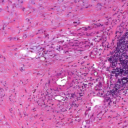

False


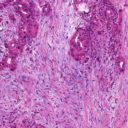

True


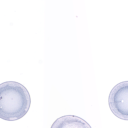

False


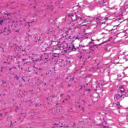

False


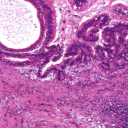

True


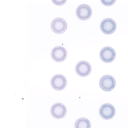

False


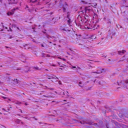

False


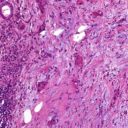

False


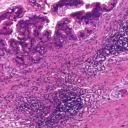

False


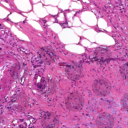

True


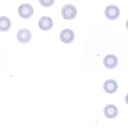

False


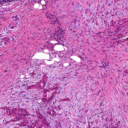

True


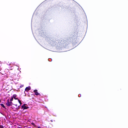

False


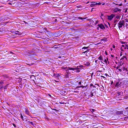

False


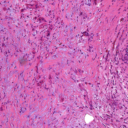

True


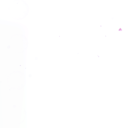

False


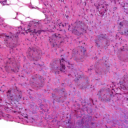

False


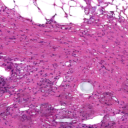

True


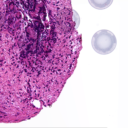

False


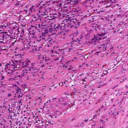

True


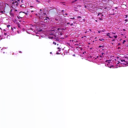

True


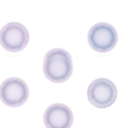

False


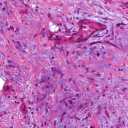

True


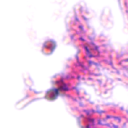

True


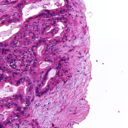

False


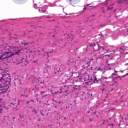

False


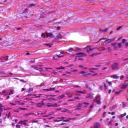

True


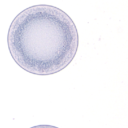

False


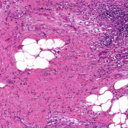

False


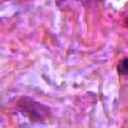

False


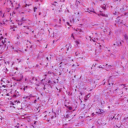

True


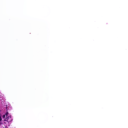

True


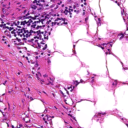

False


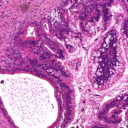

False


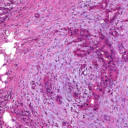

True


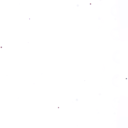

False


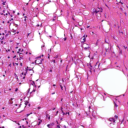

True


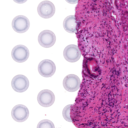

True


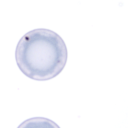

In [109]:
st_im = Image.fromarray(st_img)
for i in range(100):
    im = t(st_im)
    print(is_background(np.asarray(im), coverage=.25))
    im.show()

In [ ]:
%%time
# to_transform = staintools.read_image(fp)
to_transform = s
to_transform = staintools.LuminosityStandardizer.standardize(to_transform)
transformed = normalizer.transform(to_transform)

In [ ]:
%%time
# to_transform = staintools.read_image(fp)
to_transform = s[:150, :150]
augmentor = staintools.StainAugmentor(method='vahadane', sigma1=0.2, sigma2=0.2)
augmentor.fit(to_transform)
augmented_images = []
for _ in range(100):
    augmented_image = augmentor.pop().astype(np.uint8)
    print(np.max(augmented_image))
    plt.imshow(augmented_image)
    plt.show()
    augmented_images.append(augmented_image)

In [ ]:
transformed.shape

In [ ]:
im = Image.fromarray(s)
im.save('/home/estorrs/violet/violet/data/stain_reference.jpeg')

In [ ]:
from skimage.transform import rescale
plt.imshow(transformed)

In [ ]:
from skimage.transform import rescale
plt.imshow(transformed[14000:14100, 14000:14100])

In [ ]:
from skimage.transform import rescale
plt.imshow(transformed[:100, :100])

In [ ]:
from skimage.transform import rescale
plt.imshow(img[14000:14100, 14000:14100])

In [ ]:
plt.imshow(transformed[:100, :100])

In [ ]:
%%time
t_imgs, t_ids = extract_tif_tiles(['/data/spatial_transcriptomics/highres_images/pdac/B1-HT264P1-S1H2Fc2U1.tif'])

In [ ]:
import matplotlib.pyplot as plt
for img in t_imgs[:100]:
    plt.imshow(img)
    plt.show()

In [ ]:
%%time
s_imgs, s_ids = extract_svs_tiles({'s1': '/data/tcia/PDA/C3L-00017-22.svs'})

In [ ]:
import matplotlib.pyplot as plt
for img in s_imgs[:100]:
    plt.imshow(img)
    plt.show()

In [ ]:
for fp in fps:
    img = np.array(default_loader(fp))
    plt.imshow(img)
    plt.show()

    n = normalize_he_image(img)
    plt.imshow(n)
    plt.show()